### Map the location of SONYC Sensors

In [1]:
import sys
import urllib
from os import listdir, rename
from os.path import isfile, join, isdir
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from geopandas.tools import sjoin
from fiona.crs import from_epsg
import zipfile
import descartes

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

In [2]:
# find the location of all sensors around Washington Square Park and Identify the Sensors in park
sensors = pd.read_json(config.dataFol+"sonyc_test.collection.json")
sensors = sensors[['fqdn', 'position']]

# cleaning for lat long of the sensors from position value in json
sensors_positions1 = sensors['position'].str.split(",", n = 2, expand = True).rename(columns={0:"y1", 1:"x1"})
sensors_positions2 = sensors_positions1['y1'].str.split(" ", n=2, expand=True).rename(columns={0:"point", 1:"x2", 2:"y2"})

sensors_positions2['x2'] = np.where(sensors_positions2['x2'].notnull(),
                                   sensors_positions2['x2'].str.slice(start=1), None)
sensors_positions2['y2'] = np.where(sensors_positions2['y2'].notnull(),
                                   sensors_positions2['y2'].str[:-1], None)
sensor_positions = pd.concat([sensors_positions1, sensors_positions2], axis=1)
sensor_positions['lat'] = np.where(sensor_positions['y2'].isnull(), 
                                   sensor_positions['y1'], sensor_positions['y2'])
sensor_positions['long'] = np.where(sensor_positions['y2'].isnull(), 
                                   sensor_positions['x1'], sensor_positions['x2'])
sensor_positions.drop(columns = ['x1', 'y1', 'point', 'y2', 'x2'], inplace=True)
sensors = pd.concat([sensors,sensor_positions], axis=1)
sensors['lat'] = pd.to_numeric(sensors.lat)
sensors['long'] = pd.to_numeric(sensors.long)
sensors

,fqdn,position,lat,long
0,sonycnode-b827ebed47a6.sonyc,POINT (-73.946357 40.812207),40.812207,-73.946357
1,sonycnode-b827eb74a9e8.sonyc,"40.754965,-73.990174",40.754965,-73.990174
2,sonycnode-b827ebafe148.sonyc,"40.693831,-73.986177",40.693831,-73.986177
3,sonycnode-b827ebe3b72c.sonyc,"40.675217,-74.015617",40.675217,-74.015617
4,sonycnode-b827eb0535b8.sonyc,,NaN,NaN
...,...,...,...,...
96,sonycnode-b827ebc6dcc6.sonyc,"40.729051,-73.995349",40.729051,-73.995349
97,sonycnode-b827eb0fedda.sonyc,"40.730419,-73.998614",40.730419,-73.998614
98,sonycnode-b827ebcf5bfc.sonyc,,NaN,NaN
99,sonycnode-b827eb132382.sonyc,"40.727653,-73.993180",40.727653,-73.993180


In [3]:
bird_sensors = ['sonycnode-b827eb815321.sonyc', # 19 Washington Square North - 15-61 Washington Square N, New York, NY 10011
                'sonycnode-b827eb8e2420.sonyc', # 4 Washington Square North 1-6 Washington Square North, New York, NY 10003
                'sonycnode-b827eb86d458.sonyc', # Silver Lab - 60 5th Ave
                'sonycnode-b827eb905497.sonyc', # Kimmel Center	60 Washington Square S, New York, NY 10012
                'sonycnode-b827eb0fedda.sonyc', # Juan Carlos	King Juan Carlos I of Spain Center, 53 Washington Square S, New York, NY 10012
                'sonycnode-b827eb1685c7.sonyc'] # Shimkin Reading Room	35-51 West 4th Street, New York, NY 10012

sensors['bird_sensor'] = np.where(sensors.fqdn.isin(bird_sensors), 1,0)

##### Download NYC Streets Shapes

In [4]:
## a few if-statements to check the files so that we are not downloading and unzipping each time

if isdir(config.dataFol + 'NYC_Parks') == True and len(listdir(config.dataFol + 'NYC_Parks')) == 4:
    print("files are in place, good to go")
else:
    if isfile(config.dataFol + 'NYC_Parks.zip') == True:
        print("file is downloaded but need to be unzipped")
        # unzip the PUMAS folder
        nyc_pumas_zip = zipfile.ZipFile(config.dataFol +'NYC_Parks.zip')
        nyc_pumas_zip.extractall(config.dataFole + 'NYC_Parks')
        nyc_pumas_zip.close()
    else:
        print("need to download, move, and unzip the files")
        # download the shape file as a zip folder
        urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/g84h-jbjm?method=export&format=Shapefile", "NYC_Parks.zip")
        # move the zip file to the data folder
        shutil.move('NYC_Parks.zip', config.dataFol)
        nyc_pumas_zip = zipfile.ZipFile(config.dataFol + 'NYC_Parks.zip')
        nyc_pumas_zip.extractall(config.dataFol +'NYC_Parks')
        nyc_pumas_zip.close()

files are in place, good to go


In [5]:
# rename the files in the unzipped folder
for file in (listdir(config.dataFol + 'NYC_Parks' + '/')):
    path = (config.dataFol + 'NYC_Parks' + '/')
    if file.endswith(".dbf"):
        rename(path + file, path + 'NYC_Parks' + '.dbf')
    if file.endswith(".prj"):
        rename(path + file, path + 'NYC_Parks' + '.prj')
    if file.endswith(".shp"):
        rename(path + file, path + 'NYC_Parks' + '.shp')
    if file.endswith(".shx"):
        rename(path + file, path + 'NYC_Parks' + '.shx')

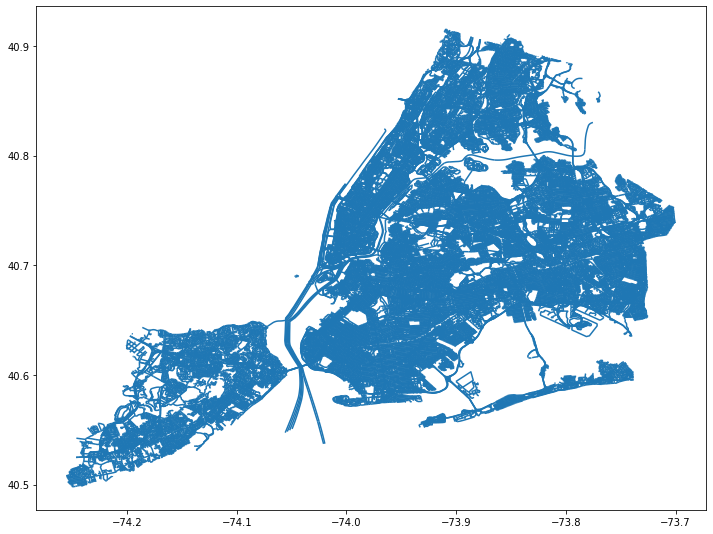

In [6]:
street_map = gpd.read_file(config.dataFol + 'NYC_Streets/NYC_Streets.shp')
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax)

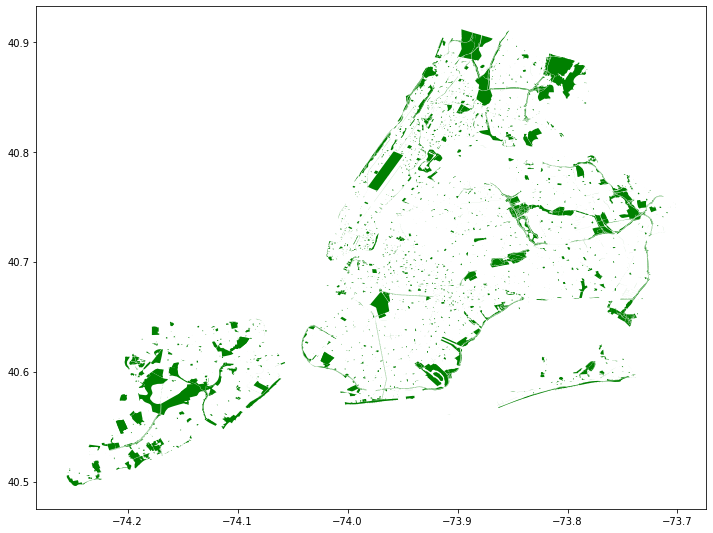

In [7]:
parks_map = gpd.read_file(config.dataFol + 'NYC_Parks/NYC_Parks.shp')
fig, ax = plt.subplots(figsize=(12,12))
parks_map.plot(ax=ax, color = 'green')

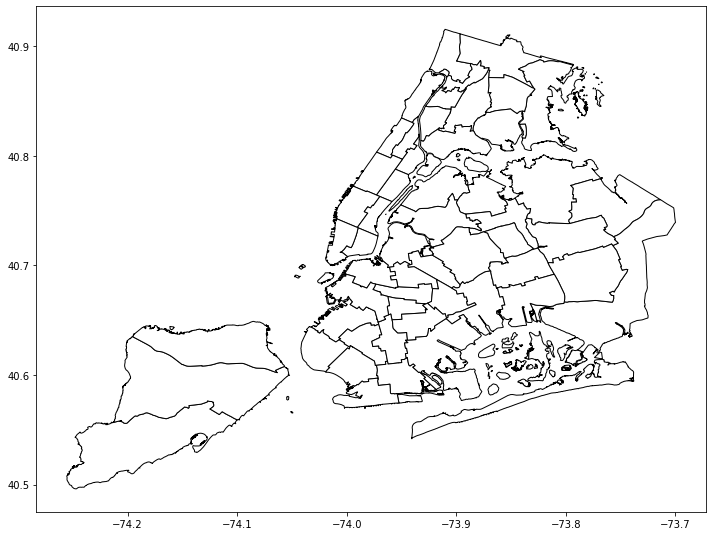

In [35]:
puma_map = gpd.read_file(config.dataFol + 'NYC_PUMAS/NYC_PUMAS.shp')
fig, ax = plt.subplots(figsize=(12,12))
puma_map.plot(ax=ax, color = 'white',edgecolor = 'black')

In [8]:
street_map.crs

{'init': 'epsg:4326'}

In [9]:
crs = {'init': 'espg:4326'}
sensors_gpd = gpd.GeoDataFrame(sensors, crs = crs , geometry=gpd.points_from_xy(sensors.long, sensors.lat))

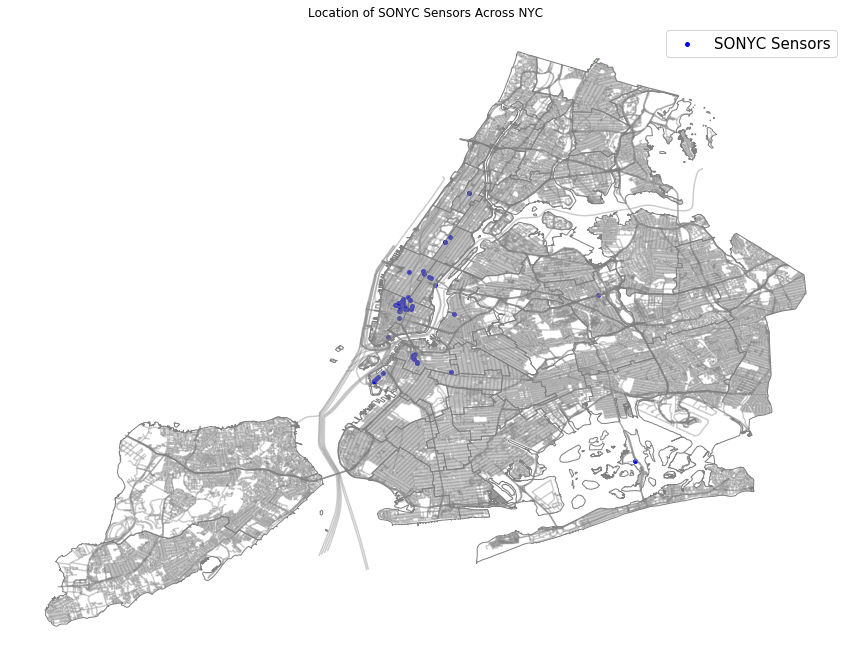

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.3, color ='grey')
parks_map.plot(ax=ax, alpha=0.3, color = 'green')
puma_map.plot(ax=ax, color = 'white', edgecolor = 'grey')
sensors_gpd.plot(ax=ax, markersize = 15, color = 'blue', marker='o', label = 'SONYC Sensors')
plt.legend(prop={"size":15})
plt.axis('off')
ax.set_title('Location of SONYC Sensors Across NYC')
plt.savefig('sonyc_locations.png')

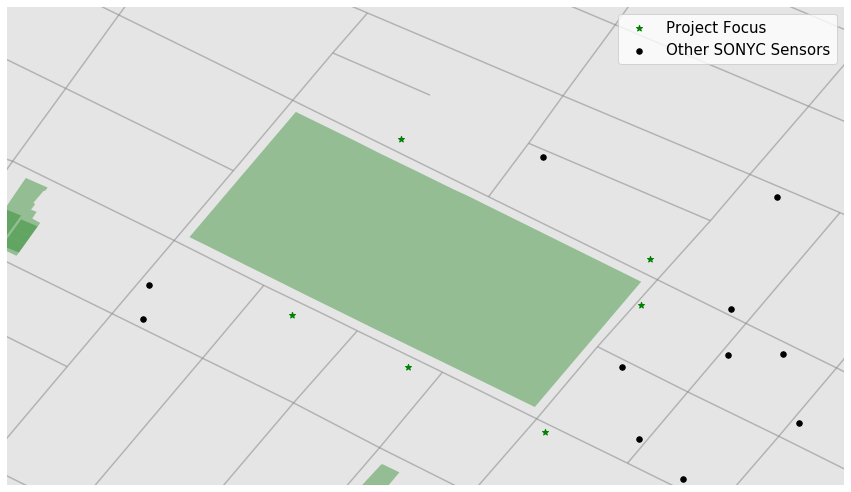

In [44]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.5, color ='grey')
parks_map.plot(ax=ax, alpha=0.4, color = 'green')
puma_map.plot(ax=ax,  alpha = 0.2, color = 'grey', edgecolor = 'grey')
sensors_gpd[sensors_gpd.bird_sensor==1].plot(ax=ax, markersize = 40, color = 'green', marker='*', label = 'Project Focus')
sensors_gpd[sensors_gpd.bird_sensor==0].plot(ax=ax, markersize = 30, color = 'black', marker='o', label = 'Other SONYC Sensors')
plt.legend(prop={"size":15})
plt.axis('off')
ax.set_xlim(-74.001, -73.994)
ax.set_ylim(40.729, 40.733)
plt.savefig('washington_square_park_locations.png')

In [48]:
names = pd.read_json(config.dataFol+"sonyc_test.collection.json")
names[names.fqdn.isin(bird_sensors)][['fqdn', 'title']]

,fqdn,title
74,sonycnode-b827eb905497.sonyc,Kimmel Center
76,sonycnode-b827eb8e2420.sonyc,4 Washington Square North
87,sonycnode-b827eb1685c7.sonyc,Shimkin Reading Room
88,sonycnode-b827eb815321.sonyc,19 Washington Square North
93,sonycnode-b827eb86d458.sonyc,Silver lab
97,sonycnode-b827eb0fedda.sonyc,Juan Carlos
